In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('src/')

In [2]:
import os
from omegaconf import OmegaConf
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
from safetensors.torch import load_file
import torch
from torchvision.utils import make_grid, save_image

from csbm.data import Prior

In [3]:
def init_and_load_model(class_name, config, checkpoint_path):
    model = class_name(
        input_dim=config.data.dim if config.data.type != 'quantized_images' else config.data.latent_dim,
        num_categories=config.data.num_categories, 
        num_timesteps=config.data.num_timesteps,
        **OmegaConf.to_object(config.model) # type: ignore
    )
    checkpoint = load_file(checkpoint_path)
    new_state_dict = {}
    for key, value in checkpoint.items():  
        new_key = key.replace("module.", "") 
        new_state_dict[new_key] = value
    
    model.load_state_dict(new_state_dict)
    model = model.eval()
    return model

def print_num_params(model):
    print(f'Loaded model with {sum(p.numel() for p in model.parameters())} parameters!')

# Swiss-Roll

In [4]:
from csbm.data import DiscreteGaussianDataset, DiscreteSwissRollDataset
from csbm.models.toy import D3PM
from csbm.utils import convert_to_numpy, visualize_trajectory_toy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def visualize_marginals(
    x: torch.Tensor | None = None, 
    y: torch.Tensor | None = None
):
    x = convert_to_numpy(x)
    y = convert_to_numpy(y)
    _, ax = plt.subplots(1, 1, figsize=(5, 5),squeeze=True,sharex=True,sharey=True, dpi=200)

    if x is not None:
        ax.scatter(x[:, 0], x[:, 1], c="g", edgecolor='black', label=r'Input distribution $p_0$', s=40, alpha=0.5, linewidth=0.8)
    if y is not None:
        ax.scatter(y[:, 0], y[:, 1], c="orange", edgecolor='black', label=r'Output distribution $p_1$', s=40, linewidth=0.8)
    # ax.grid()
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.set_xlim((7.0, 43.0))
    ax.set_ylim((7.0, 43.0))
    ax.legend(loc="lower left")
    plt.show()

In [6]:
exps_dir = './experiments/toy/swiss_roll' 
exp_names = [
    'gaussian/dim_2_aplha_0.02_16.05.25_16:33:49',
    'gaussian/dim_2_aplha_0.05_16.05.25_16:34:59',
    'uniform/dim_2_aplha_0.005_16.05.25_16:44:57',
    'uniform/dim_2_aplha_0.01_16.05.25_17:13:51',
    'gaussian/dim_2_aplha_0.02_no_ce_no_kl_16.05.25_13:59:45',
    'gaussian/dim_2_aplha_0.05_no_ce_no_kl_16.05.25_14:08:38',
    'uniform/dim_2_aplha_0.005_no_ce_no_kl_16.05.25_14:23:31',
    'uniform/dim_2_aplha_0.01_no_ce_no_kl_16.05.25_14:44:37',
]

/beegfs/home/g.ksenofontov/Projects/csbm/src/csbm/data.py:53: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  discrete_batch = torch.bucketize(batch, bin_edges)


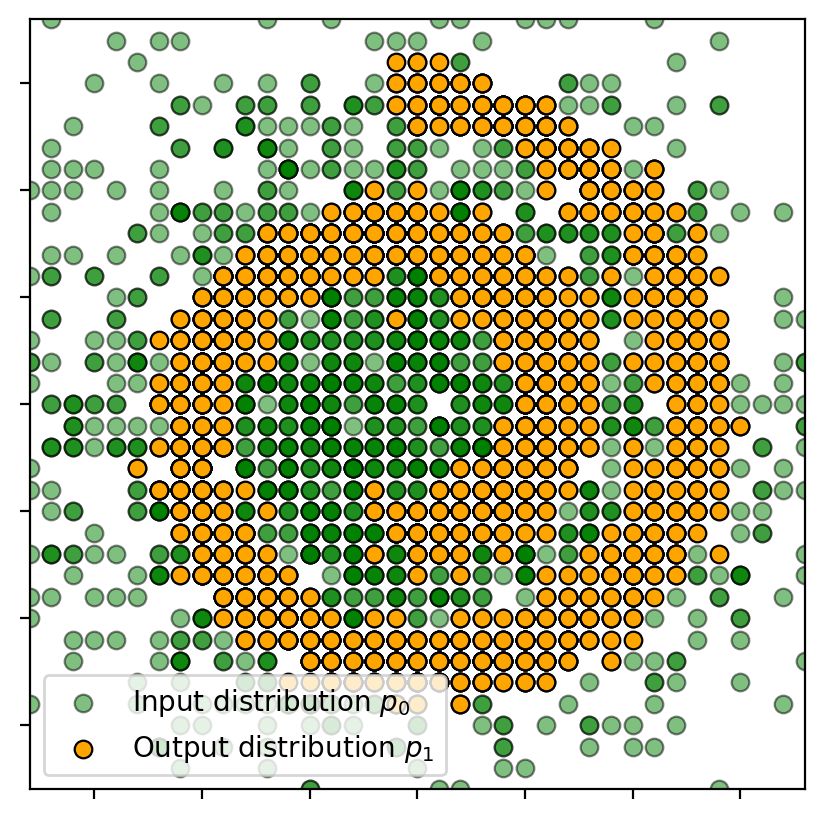

In [7]:
num_categories = 50
num_timesteps = 10

dataset_x = DiscreteGaussianDataset(5000, dim=2, num_categories=num_categories, train=False)
dataset_y = DiscreteSwissRollDataset(5000, num_categories=num_categories, train=False)

visualize_marginals(x=dataset_x[4:2005], y=dataset_y[4:2005])

Loaded model with 46588 parameters!


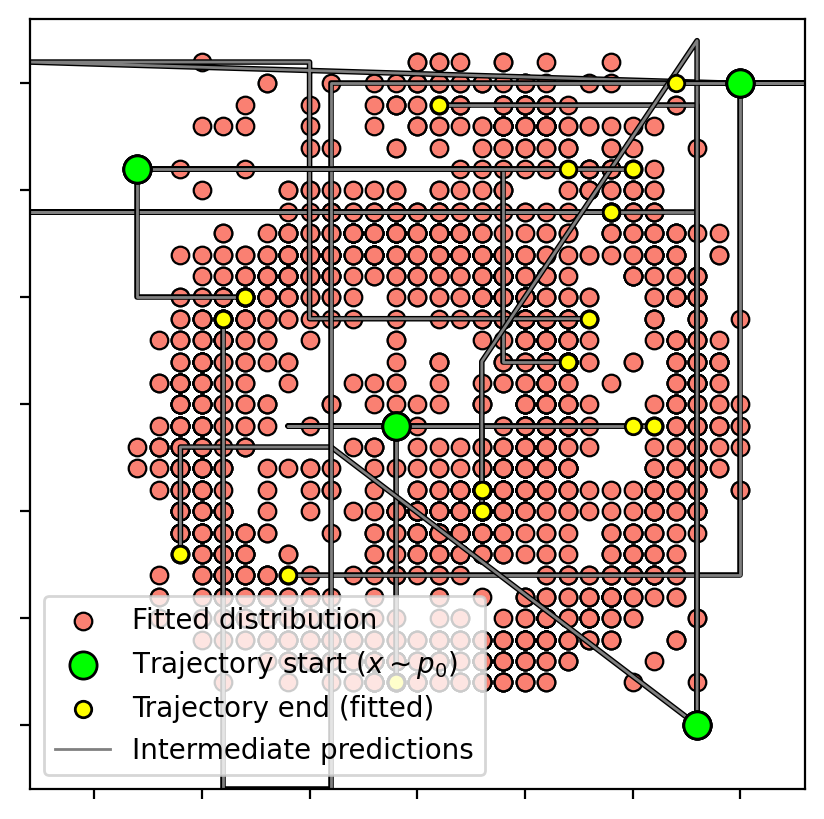

In [178]:
exp_id = 7

exp_name = exp_names[exp_id]
exp_path = os.path.join(exps_dir, exp_name)
config = OmegaConf.load(os.path.join(exp_path, 'config.yaml'))
checkpoint_path = os.path.join(exp_path, 'checkpoints', 'forward_10', 'model.safetensors')
model = init_and_load_model(D3PM, config, checkpoint_path).to(device)
print_num_params(model)
prior = Prior(
    alpha=config.prior.alpha, 
    num_categories=config.data.num_categories, 
    num_timesteps=config.data.num_timesteps, 
    num_skip_steps=config.data.num_skip_steps, 
    prior_type=config.prior.type,
    eps=config.prior.eps,
).to(device)

generations = []
test_x_end = dataset_x[:2048].to(device)
pred_x_start = model.sample(test_x_end, prior)

traj_start = test_x_end[:4]
repeats = [4] + [1] * traj_start.dim()
trajectories = traj_start.unsqueeze(0).repeat(*repeats)
trajectories = trajectories.reshape(-1, *traj_start.shape[1:])
trajectories = trajectories.to(device)
trajectories = model.sample_trajectory(trajectories, prior)
visualize_trajectory_toy(
    pred_x_start, trajectories, 'forward', 
    figsize=(5, 5), dpi=200, use_legend=True, axlim=(7, 43)
)

# CMNIST

In [165]:
from csbm.data import DiscreteColoredMNISTDataset
from csbm.models.images import ImageD3PM

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [166]:
import colorsys

def change_image_hue(image_tensor, target_hue):
    target_hue = target_hue/360
    assert image_tensor.ndim == 3 and image_tensor.shape[0] == 3, "Input must be a 3-channel image tensor (3, H, W)."
    assert 0 <= target_hue <= 1, "Target hue must be in the range [0, 1]."
    
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    result_np = image_np.copy()
    for i in range(result_np.shape[0]):
        for j in range(result_np.shape[1]):
            r, g, b = result_np[i, j]
            h, s, v = colorsys.rgb_to_hsv(r, g, b)
            h = target_hue  # Set the desired hue
            r, g, b = colorsys.hsv_to_rgb(h, s, v)
            result_np[i, j] = [r, g, b]
    
    result_tensor = torch.tensor(result_np).permute(2, 0, 1)
    
    return result_tensor

In [177]:
# exps_dir = './experiments/images/cmnist/gaussian/'
exps_dir = './experiments/images/cmnist/uniform/' 
exp_names = [
    # 'dim_32_aplha_0.01_27.01.25_14:51:51', # 2 steps
    # 'dim_32_aplha_0.01_29.01.25_10:02:47', # 4 steps
    # 'dim_32_aplha_0.01_28.01.25_15:30:39', # 10 steps
    # 'dim_32_aplha_0.01_29.01.25_20:37:01', # 25 steps
    # 'dim_32_aplha_0.01_26.05.25_16:14:39', # 50 steps
    # 'dim_32_aplha_0.01_21.05.25_05:58:37', # 100 steps
    'dim_32_aplha_0.01_26.03.25_18:13:18', # alpha = 0.01
    'dim_32_aplha_0.05_26.03.25_18:09:45', # alpha = 0.05
]
num_steps = [
    # 2, 
    # 4, 
    # 10, 
    # 25, 
    # 50, 
    # 100,
    25, 
    25
]

In [181]:
fb = 'backward' # 'forward' or 'backward'

num_samples = 4
dataset = DiscreteColoredMNISTDataset(
    target_digit=3 if fb == 'forward' else 2, img_size=32, 
    data_dir='data/', train=False
)
cherry_pick_threes = torch.stack([
    change_image_hue(dataset[0], 135 if fb == 'forward' else 137),
    change_image_hue(dataset[1], 42 if fb == 'forward' else 228),
    change_image_hue(dataset[3], 276 if fb == 'forward' else 42),
    change_image_hue(dataset[7], 312 if fb == 'forward' else 3)
], dim=0)
save_image(cherry_pick_threes/255, f'images/cmnist/cmnist_pics_orig_vert_{fb}.png', normalize=True, nrow=1)

In [ ]:
for i, exp_name in enumerate(exp_names):
    exp_path = os.path.join(exps_dir, exp_name)
    config = OmegaConf.load(os.path.join(exp_path, 'config.yaml'))
    checkpoint_path = os.path.join(exp_path, 'checkpoints', f'{fb}_3' if num_steps[i] != 2 else 'forward_3', 'model.safetensors')
    model = init_and_load_model(ImageD3PM, config, checkpoint_path).to(device)
    print_num_params(model)
    prior = Prior(
        alpha=config.prior.alpha, 
        num_categories=config.data.num_categories, 
        num_timesteps=config.data.num_timesteps, 
        num_skip_steps=config.data.num_skip_steps, 
        prior_type=config.prior.type,
        eps=config.prior.eps,
    ).to(device)

    generations = []
    for three in tqdm(cherry_pick_threes):
        images = three.unsqueeze(0).repeat(num_samples, 1, 1, 1).to(device)
        generation = model.sample(images, prior)
        generations.append(generation)
    generations = torch.cat(generations, dim=0).float()
    
    save_image(generations, f'images/cmnist/csbm_{num_steps[i]}_{fb}.png', normalize=True, nrow=4)

Loaded model with 34780608 parameters!


  0%|          | 0/4 [00:00<?, ?it/s]

Loaded model with 34780608 parameters!


  0%|          | 0/4 [00:00<?, ?it/s]

# CelebA

In [170]:
from csbm.data import CelebaDataset
from csbm.models.quantized_images import LatentD3PM, Codec

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [171]:
exps_dir = 'experiments/quantized_images/celeba/uniform/' 
exp_names = [
    'dim_128_aplha_0.005_14.03.25_00:25:49',
    'dim_128_aplha_0.01_13.03.25_19:29:49',
]
alphas = [0.005, 0.01]

In [172]:
exp_id = 1
fb = 'backward'

exp_path = os.path.join(exps_dir, exp_names[exp_id])
config = OmegaConf.load(os.path.join(exp_path, 'config.yaml'))
checkpoint_path = os.path.join(exp_path, 'checkpoints', f'{fb}_5', 'model.safetensors')
model = init_and_load_model(LatentD3PM, config, checkpoint_path).to(device)
print_num_params(model)

dataset = CelebaDataset(
    'female' if fb == 'forward' else 'male', size=128, 
    data_dir='data/', 
    train=False, return_names=True
)

codec = Codec(
    config_path=os.path.join('.', config.codec.config_path),
    ckpt_path=os.path.join('.', config.codec.ckpt_path),     
).eval()
print_num_params(codec)


prior = Prior(
    alpha=config.prior.alpha, 
    num_categories=config.data.num_categories, 
    num_timesteps=config.data.num_timesteps, 
    num_skip_steps=config.data.num_skip_steps, 
    prior_type=config.prior.type
).to(device)

Loaded model with 93084928 parameters!
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/beegfs/home/g.ksenofontov/Projects/csbm/src/csbm/models/quantized_images.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locatio

KeyboardInterrupt: 

#### Generation images

In [ ]:
num_samples = 4
if fb == 'forward':
    cherry_pick_ids = ['180967.jpg', '180968.jpg', '180974.jpg', '180980.jpg']
else:
    cherry_pick_ids = ['183359.jpg', '183360.jpg', '183364.jpg', '183375.jpg']

generations = []
for idx in tqdm(cherry_pick_ids):
    images = dataset.get_by_filename(idx).unsqueeze(0).repeat(num_samples, 1, 1, 1)
    encoded_test_x_end = codec.encode_to_cats(images).to(device) # type: ignore
    generation = model.sample(encoded_test_x_end, prior).cpu()
    generation = codec.decode_to_image(generation)
    generations.append(generation)
generations = torch.cat(generations, dim=0)
save_image(generations, f'./images/celeba/csbm_{alphas[exp_id]}_{fb}.png', normalize=True, nrow=4)

  0%|          | 0/4 [00:00<?, ?it/s]

#### Trajectory images

In [ ]:
times = [10, 25, 50, 75, 90, 101]
if fb == 'forward':
    cherry_pick_ids = [
        '012721.jpg',         
        '191286.jpg',
        '191291.jpg',
        '191294.jpg',
        '191296.jpg',
        '191297.jpg',
        '191298.jpg',
        '191299.jpg',
    ]
else:
    cherry_pick_ids = [
        '191287.jpg',
        '191292.jpg',
        '191295.jpg',
        '191301.jpg',
        '191302.jpg',
        '191306.jpg',
        '191307.jpg',
        '191313.jpg',
    ]
trajectories = []
for idx in tqdm(cherry_pick_ids):
    images = dataset.get_by_filename(idx).unsqueeze(0)
    encoded_test_x_end = codec.encode_to_cats(images).to(device) # type: ignore
    trajectory = model.sample_trajectory(encoded_test_x_end, prior).cpu()
    trajectory = codec.decode_to_image(trajectory.reshape(-1, *encoded_test_x_end.shape[1:]))
    trajectory = trajectory.reshape(-1, *images.shape[1:])
    
    trajectories.append(torch.cat([images.cpu(), trajectory[times]], dim=0))
trajectories = torch.cat(trajectories, dim=0)
save_image(trajectories, f'./images/celeba/csbm_traj_{alphas[exp_id]}_{fb}.png', normalize=True, nrow=7)

  0%|          | 0/8 [00:00<?, ?it/s]

'./images/celeba/csbm_traj_0.01_backward.png'

# Amazon

In [ ]:
from csbm.data import AmazonDataset
from csbm.models.texts import TextD3PM
from transformers import PreTrainedTokenizerFast

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
exps_dir = 'experiments/texts/amazon/uniform/' 
exp_names = [
    'dim_100_aplha_0.005_16.05.25_23:12:19',
    'dim_100_aplha_0.01_20.05.25_17:47:55',
]
alphas = [0.005, 0.01]

In [ ]:
exp_id = 0
fb = 'forward'

exp_path = os.path.join(exps_dir, exp_names[exp_id])
config = OmegaConf.load(os.path.join(exp_path, 'config.yaml'))
checkpoint_path = os.path.join(exp_path, 'checkpoints', f'{fb}_5', 'model.safetensors')
model = init_and_load_model(TextD3PM, config, checkpoint_path).to(device)
print_num_params(model)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=config.tokenizer.path,
    padding_side='right',
    truncation_side='right',
    bos_token='<s>',
    pad_token='<pad>',
)

prior = Prior(
    alpha=config.prior.alpha, 
    num_categories=config.data.num_categories, 
    num_timesteps=config.data.num_timesteps, 
    num_skip_steps=config.data.num_skip_steps, 
    prior_type=config.prior.type
).to(device)

RuntimeError: Error(s) in loading state_dict for TextD3PM:
	size mismatch for model.vocab_embed.embedding: copying a param with shape torch.Size([4843, 768]) from checkpoint, the shape in current model is torch.Size([8192, 768]).
	size mismatch for model.output_layer.linear.weight: copying a param with shape torch.Size([4843, 768]) from checkpoint, the shape in current model is torch.Size([8192, 768]).
	size mismatch for model.output_layer.linear.bias: copying a param with shape torch.Size([4843]) from checkpoint, the shape in current model is torch.Size([8192]).

In [ ]:
if fb == 'forward':
    texts = [
        'movie was a waste of money : this movie totally sucks .',
        'nothing truly interesting happens in this book .'
    ]
else:
    texts = [
        'my daughter loves them :)',
        'best fit for my baby : this product is wonderful !!'
    ]
tokens = tokenizer.encode(
    text=texts, 
    padding='max_length', 
    truncation=True, 
    max_length=config.data.dim,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=False,
)
samples = model.sample(tokens, prior) # type: ignore
tokenizer.batch_decode(samples.cpu(), skip_special_tokens=True)

NameError: name 'tokenizer' is not defined